In [2]:
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../experiments")


from experiment_information import *
from experiment_setup import *
from data import *
from helpers import *
from data_loading import *
import matplotlib.pyplot as plt


import pandas as pd
import numpy as np
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import numpy as np
import re
%load_ext autoreload
%autoreload 2



This code assumes that you have defined and run an experiment before using `define_experiment.ipynb` in the `experiments` folder.

In [3]:
df_experiments, df_state_evolution, df_erm = obtain_dataframes(logger)
df_experiments.head(5)

Current code version, 112


,experiment_id,experiment_name,duration,problem_types,code_version,date,state_evolution_repetitions,erm_repetitions,alphas,epsilons,...,taus,ps,dp,d,experiment_type,completed,data_model_types,data_model_names,data_model_descriptions,gamma_fair_error
19,59dde9db-a58e-44be-ad31-bd9c113aeeaf,Vanilla,14.796518,"[""Logistic""]",112,2024-05-09 17:50:52,1,0,[1.5],"[0.01, 0.0167, 0.0278, 0.0464, 0.0774, 0.1292,...",...,[0.01],null,0.01,2000,Sweep,1,"[""VanillaGaussian""]","[""KFeaturesModel_TwoFeatures_Vanilla_[0.5 0.5]...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
17,1f510e29-a43c-4667-8335-c198df6c6a7c,DifferentSigmaW,210.747429,"[""Logistic""]",112,2024-04-26 18:01:02,1,0,"[0.001, 0.0012, 0.0014, 0.0017, 0.002, 0.0024,...",[0.15],...,[0.01],null,0.01,2000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_NonuniformProtect...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
16,f4521deb-b51a-4f54-95ec-0aed3815a2cb,DifferentSigmaW,210.962575,"[""Logistic""]",112,2024-04-26 17:55:43,1,0,"[0.001, 0.0012, 0.0014, 0.0017, 0.002, 0.0024,...",[0.1],...,[0.01],null,0.01,2000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_NonuniformProtect...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
15,b1b456ce-a742-4b64-95b7-ec114c9bcd85,DifferentSigmaW,220.322536,"[""Logistic""]",112,2024-04-26 17:46:40,1,0,"[0.001, 0.0012, 0.0014, 0.0017, 0.002, 0.0024,...",[0.2],...,[0.01],null,0.01,2000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_NonuniformProtect...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
14,324dcd5a-57f0-4194-9ec5-74d6dc074bf8,DifferentSigmaW,130.311010,"[""Logistic""]",112,2024-04-26 13:50:52,1,0,"[0.001, 0.0013, 0.0018, 0.0024, 0.0032, 0.0043...",[0.2],...,[0.01],null,0.01,2000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_NonuniformProtect...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001


In [4]:
experiment_loc = 0

# extract and print the top experiment_id
experiment_id = df_experiments.iloc[experiment_loc]["experiment_id"]
print(experiment_id)

# extract and print the experiment type
experiment_type = df_experiments.iloc[experiment_loc]["experiment_type"]
print(experiment_type)

# extract and print the data model type and data_model name used
data_model_types = df_experiments.iloc[experiment_loc]["data_model_types"]
# convert it to the enum
data_model_types = [DataModelType[data_model_type] for data_model_type in json.loads(data_model_types)]
data_model_names = [name for name in json.loads(df_experiments.iloc[experiment_loc]["data_model_names"])]
data_model_descriptions = df_experiments.iloc[experiment_loc]["data_model_descriptions"]
for data_model_type in data_model_types:
    print(data_model_type.name)
print(data_model_names)
print(data_model_descriptions)

# print the experiment name
experiment_name = df_experiments.iloc[experiment_loc]["experiment_name"]
print(experiment_name)

# print the experiment problem types
experiment_problem_types = df_experiments.iloc[experiment_loc]["problem_types"]
experiment_problem_types = json.loads(experiment_problem_types)
print(experiment_problem_types)

59dde9db-a58e-44be-ad31-bd9c113aeeaf
Sweep
VanillaGaussian
['KFeaturesModel_TwoFeatures_Vanilla_[0.5 0.5]_[1 1]_[1 1]_SD_1_1_SU_1_1___Vanilla']
["2 Features, Theta Identity, Sigma_upsilon Identity, Sigma_delta Identity"]
Vanilla
['Logistic']


In [210]:
# name for the plots ----
data_model_name_dict = {}
data_model_name_dict["VanillaGaussian"] = "Vanilla Gaussian"
data_model_name_dict["2_VanillaGaussian"] = "Vanilla Gaussian"
data_model_name_dict["VanillaGaussianThetaFirst"] = "Vanilla Gaussian - Teacher 10:1"
data_model_name_dict["VanillaGaussianTimes10"] = "Vanilla Gaussian x10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]"] = "Strong Weak 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1 1]"] = "Strong Weak 5:1"
data_model_name_dict["2_KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1 1]"] = "Strong Weak 5:1"
data_model_name_dict["2_KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]"] = "Strong Weak 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[10  1]"] = "Strong Weak 5:1 - Teacher 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[10  1]"] = "Strong Weak 10:1 - Teacher 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[ 1 10]"] = "Strong Weak 5:1 - Teacher 1:10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[ 1 10]"] = "Strong Weak 10:1 - Teacher 1:10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[1 1]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Non-Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[5 5]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[5 5]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Non-Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[1 1]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[1 1]_SD_1_1_SU_1_1"] = "Non-Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[5 5]_SD_1_1_SU_1_1"] = "Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[5 5]_SD_1_1_SU_1_1"] = "Non-Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[1 1]_SD_1_1_SU_1_1"] = "Robust Non-Useful"

data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[2 2]_[2 2]_SD_1_1_SU_1_1"] = "Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[4 4]_SD_1_1_SU_1_1"] = "Non-Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[2 2]_[0.5 0.5]_SD_1_1_SU_1_1"] = "Robust Non-Useful"


data_model_name_dict['KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[0.5 0.5]_[2 2]_SD_1_1_SU_1_1'] = "Non-Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[0.5 0.5]_[8 8]_SD_1_1_SU_1_1"] = "Non-Robust Useful"


data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[2.  0.5]_[1 1]_SD_1_1_SU_1_1"] = "Invariant Defence"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingFirstStronger_AttackingIdentity_[0.5 0.5]_[2.  0.5]_[1 1]_SD_2_1_SU_1_1"] = "Protecting Robust"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[2.  0.5]_[1 1]_SD_1_2_SU_1_1"] = "Protecting Non-Robust"


data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[1 1]_SD_1_1_SU_1_1"] = "Invariant Defence"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingFirstStronger_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[1 1]_SD_2_1_SU_1_1"] = "Protecting Robust"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[1 1]_SD_1_2_SU_1_1"] = "Protecting Non-Robust"


data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[0.2 5. ]_SD_1_1_SU_1_1"] = "Invariant Defence"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingFirstStronger_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[0.2 5. ]_SD_2_1_SU_1_1"] = "Protecting Robust"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[0.2 5. ]_SD_1_2_SU_1_1"] = "Protecting Non-Robust"

data_model_name_dict["KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 5]_SU_1_1_Sw_[1 1]"] = "Non-Uniform Regularisation"
data_model_name_dict["KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 5]_SU_1_1_Sw_[5 1]"] = "Opposite Regularisation"
data_model_name_dict["KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 5]_SU_1_1_Sw_[1 5]"] = "Same Regularisation"

# 'KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[0.2 5. ]_SD_1_1_SU_1_1___Defence Sweep', 'KFeaturesModel_TwoFeatures_ProtectingFirstStronger_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[0.2 5. ]_SD_2_1_SU_1_1___Defence Sweep', 'KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[0.2 5. ]_SD_1_2_SU_1_1___Defence Sweep'

In [211]:
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
gd = df_erm[df_erm["experiment_id" ] == experiment_id]
# make the column subspace_overlaps to string
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: str(x))

# create a json colum
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: json.loads(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: json.loads(x))
from pandas import json_normalize
# normalize the json column
normalized = json_normalize(state_evolution["subspace_overlaps"])
normalized_gd = json_normalize(gd["subspace_overlaps"])



def explode_array_column(row, col):
    return pd.Series(row[col])

# reset the index of the original dataframe
state_evolution = state_evolution.reset_index(drop=True)
gd = gd.reset_index(drop=True)

for col in normalized.columns:
    expanded_cols = normalized.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)
    state_evolution = pd.concat([state_evolution, expanded_cols], axis=1)

for col in normalized_gd.columns:
    expanded_cols = normalized_gd.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)

    gd = pd.concat([gd, expanded_cols], axis=1)



/var/folders/vl/6t_sjl4j16nd3xx4b0t7wd280000gn/T/ipykernel_36856/3541688095.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
/var/folders/vl/6t_sjl4j16nd3xx4b0t7wd280000gn/T/ipykernel_36856/3541688095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: json.loads(x))


In [212]:
state_evolution["subspace_overlaps_ratio"] = state_evolution["subspace_overlaps_ratio"].apply(lambda x: str(x))
state_evolution["subspace_overlaps_ratio"] = state_evolution["subspace_overlaps_ratio"].apply(lambda x: json.loads(x))
normalized = json_normalize(state_evolution["subspace_overlaps_ratio"])
# rename the columns of the normalized dataframe
for column in normalized.columns:
    normalized = normalized.rename(columns={column:column+"_ratio"})
# merge the normalized dataframe with the original dataframe
state_evolution = pd.concat([state_evolution, normalized], axis=1)
# drop the original subspace_overlaps column
state_evolution = state_evolution.drop(columns=["subspace_overlaps_ratio"])

gd["subspace_overlaps_ratio"] = gd["subspace_overlaps_ratio"].apply(lambda x: str(x))
gd["subspace_overlaps_ratio"] = gd["subspace_overlaps_ratio"].apply(lambda x: json.loads(x))
normalized = json_normalize(gd["subspace_overlaps_ratio"])
# rename the columns of the normalized dataframe
for column in normalized.columns:
    normalized = normalized.rename(columns={column:column+"_ratio"})
# merge the normalized dataframe with the original dataframe
gd = pd.concat([gd, normalized], axis=1)
# drop the original subspace_overlaps column
gd = gd.drop(columns=["subspace_overlaps_ratio"])


In [213]:
# def compute_mu_usefulness(row):
#     rho = row["rho"]
#     tau = row["tau"]

#     rho = float(rho)
#     tau = float(tau)

#     return np.sqrt(2 / np.pi) * rho / np.sqrt( rho + tau**2 )

# def compute_gamma_robustness(row):
#     rho = row["rho"]
#     tau = row["tau"]


#     rho = float(rho)
#     tau = float(tau)

#     return np.sqrt(2 / np.pi) * tau / np.sqrt( rho + tau**2 )

# def compute_mu_usefulness_ratio(row):

In [214]:
# create a column for the difference between the adversarial_generalization_error and the generalization_error for both the state evolution and the erm
state_evolution["difference_adv_gen"] = state_evolution["adversarial_generalization_error"] - state_evolution["generalization_error"]
gd["difference_adv_gen"] = gd["adversarial_generalization_error"] - gd["generalization_error_erm"]


state_evolution["ratio_adv_gen"] = state_evolution["adversarial_generalization_error"] / state_evolution["generalization_error"]
gd["ratio_adv_gen"] = gd["adversarial_generalization_error"] / gd["generalization_error_erm"]

In [215]:
# create a column for the noise contribution
def noise_contribution(rho: float, tau: float) -> float:
    if tau == 0:
        tau = 1e-10
    return 0.5 - np.arctan( np.sqrt( rho / tau**2 ) ) / np.pi

state_evolution["noise_contribution"] = state_evolution.apply(lambda x: noise_contribution(x["rho"], x["tau"]), axis=1)
gd["noise_contribution"] = gd.apply(lambda x: noise_contribution(x["rho"], x["tau"]), axis=1)

In [216]:
# create a column for the noiseless generalization error without the noise contribution
state_evolution["noiseless_generalization_error"] = state_evolution["generalization_error"] - state_evolution["noise_contribution"]
gd["noiseless_generalization_error_erm"] = gd["generalization_error_erm"] - gd["noise_contribution"]

# create a column for the adversarial noiseless generalization error without the noise contribution
state_evolution["noiseless_adversarial_generalization_error"] = state_evolution["adversarial_generalization_error"] - state_evolution["noise_contribution"]
gd["noiseless_adversarial_generalization_error"] = gd["adversarial_generalization_error"] - gd["noise_contribution"]

In [217]:
def noiseless_angle_to_generalisation(angle):
    return np.arccos(angle) / np.pi

state_evolution["noiseless_angle_to_generalisation"] = state_evolution.apply(lambda x: noiseless_angle_to_generalisation(x["angle"]), axis=1)
gd["noiseless_angle_to_generalisation"] = gd.apply(lambda x: noiseless_angle_to_generalisation(x["angle"]), axis=1)

In [218]:
# create a column for the A/sqrt(q*N) for both the state evolution and the erm
state_evolution["A_over_sqrt_qN"] = state_evolution["A"] / np.sqrt(state_evolution["q"] * state_evolution["N"])
gd["A_over_sqrt_qN"] = gd["A"] / np.sqrt(gd["q"] * gd["N"])

In [219]:
# create a column for m/sqrt( rho*q - m**2 ) vs A/sqrt(q*N) for both the state evolution and the erm
state_evolution["m_over_sqrt_rhoq_minus_m2"] = state_evolution["m"] / np.sqrt(state_evolution["rho"] * state_evolution["q"] - state_evolution["m"]**2)
gd["m_over_sqrt_rhoq_minus_m2"] = gd["m"] / np.sqrt(gd["rho"] * gd["q"] - gd["m"]**2)

In [220]:
# strip the data_model_name if there is a sequence ___text at the end
def strip_data_model_name(data_model_name):
    return re.sub(r"___.*","",data_model_name)
state_evolution["data_model_name"] = state_evolution["data_model_name"].apply(strip_data_model_name)
gd["data_model_name"] = gd["data_model_name"].apply(strip_data_model_name)

In [221]:
def extract_theta_ratio(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits in within the last square brackets
    theta_part = data_model_name.split("[")[-1].split("]")[0]
    # remove any spaces in the end
    theta_part = theta_part.strip()
    

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # determine whether the two values are split by " " or by "  "
    if "  " in theta_part:
        splitter = "  "
    else:
        splitter = " "

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    return theta_second # / theta_first  


state_evolution["theta_ratio"] = state_evolution["data_model_name"].apply(extract_theta_ratio)
gd["theta_ratio"] = gd["data_model_name"].apply(extract_theta_ratio)

In [222]:
def extract_sigmax_ratio(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits in within the last square brackets
    theta_part = data_model_name.split("[")[-2].split("]")[0]
    # remove any spaces in the end
    theta_part = theta_part.strip()

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # determine whether the two values are split by " " or by "  "
    if "  " in theta_part:
        splitter = "  "
    else:
        splitter = " "

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    return theta_first # / theta_second


state_evolution["sigmax_ratio"] = state_evolution["data_model_name"].apply(extract_sigmax_ratio)
gd["sigmax_ratio"] = gd["data_model_name"].apply(extract_sigmax_ratio)

In [223]:
def extract_sigmadelta_ratio(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits after the SD_ only
    theta_part = data_model_name.split("SD")[-1].split("SU")[0]
    # print("Post SD: ", theta_part)


    # remove leading _ and ending _
    theta_part = theta_part.strip("_")
    # print("Post strip: ", theta_part)

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # define the spliter to be "_"
    splitter = "_"

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    # print("Theta first: ", theta_first)
    # print("Theta second: ", theta_second)
    return theta_second  #/ theta_first

def extract_sigmadelta_scale(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits after the SD_ only
    theta_part = data_model_name.split("SD")[-1].split("SU")[0]
    # print("Post SD: ", theta_part)


    # remove leading _ and ending _
    theta_part = theta_part.strip("_")
    # print("Post strip: ", theta_part)

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # define the spliter to be "_"
    splitter = "_"

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    # print("Theta first: ", theta_first)
    # print("Theta second: ", theta_second)
    return theta_first


# state_evolution["sigmadelta_ratio"] = state_evolution["data_model_name"].apply(extract_sigmadelta_ratio)
# gd["sigmadelta_ratio"] = gd["data_model_name"].apply(extract_sigmadelta_ratio)

# state_evolution["sigmadelta_scale"] = state_evolution["data_model_name"].apply(extract_sigmadelta_scale)
# gd["sigmadelta_scale"] = gd["data_model_name"].apply(extract_sigmadelta_scale)

In [224]:
gd = gd.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","theta_ratio","data_model_name"]) #,"p_calibration"
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","theta_ratio","data_model_name"]) #,"p_calibration"

# drop id, code_version, experiment_id, date, initial_condition, test_against_epsilons, calibrations, abs_tol, min_iter,max_iter,blend_fpe,int_lims,subspace_overlaps
state_evolution = state_evolution.drop(columns=["id","code_version","experiment_id","date","initial_condition","test_against_epsilons","calibrations","abs_tol","min_iter","max_iter","blend_fpe","int_lims","subspace_overlaps","data_model_type","data_model_description"])
# drop id, code_version, experiment_id, test_against_epsilons, date, subspace_overlaps, analytical_calibrations, erm_calibrations, 
gd = gd.drop(columns=["id","code_version","experiment_id","test_against_epsilons","date","subspace_overlaps","analytical_calibrations","erm_calibrations","data_model_type","data_model_description"])

state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
gd.columns = [col+"_erm" for col in gd.columns]

state_evolution = state_evolution.groupby(level=[0,1,2,3,4,5,6,7,8]).agg(["mean","std"]) #,4
gd = gd.groupby(level=[0,1,2,3,4,5,6,7,8]).agg(["mean","std"]) #,4
df = state_evolution.join(gd, how="outer")
df.sort_index()
df

index_state_evolution  \
                                                                                                                                                    mean   
alpha  epsilon tau  lam    problem_type attack_epsilon sigmax_ratio theta_ratio data_model_name                                                            
0.0010 0.15    0.01 0.0001 Logistic     0.2            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection...                 923.0   
                                                                                KFeaturesModel_TwoFeatures_NonuniformProtection...                 969.0   
                                                                    5.0         KFeaturesModel_TwoFeatures_NonuniformProtection...                1020.0   
0.0012 0.15    0.01 0.0001 Logistic     0.2            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection...                 921.0   
                                                                                KFeaturesModel_TwoFeatures_NonuniformProtection...                 971.0   
...                                                                                                                                                  ...   
4.2022 0.15    0.01 0.0001 Logistic     0.2            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection...                1017.0   
                                                                    5.0         KFeaturesModel_TwoFeatures_NonuniformProtection...                1068.0   
5.0000 0.15    0.01 0.0001 Logistic     0.2            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection...                 970.0   
                                                                                KFeaturesModel_TwoFeatures_NonuniformProtection...                1019.0   
                                                                    5.0         KFeaturesModel_TwoFeatures_NonuniformProtection...                1069.0   

                                                                                                                                        \
                                                                                                                                   std   
alpha  epsilon tau  lam    problem_type attack_epsilon sigmax_ratio theta_ratio data_model_name                                          
0.0010 0.15    0.01 0.0001 Logistic     0.2            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
                                                                                KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
                                                                    5.0         KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
0.0012 0.15    0.01 0.0001 Logistic     0.2            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
                                                                                KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
...                                                                                                                                 ..   
4.2022 0.15    0.01 0.0001 Logistic     0.2            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
                                                                    5.0         KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
5.0000 0.15    0.01 0.0001 Logistic     0.2            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
                                                                                KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
                                                                    5.0         KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   

             

In [225]:
# def extract_rho_norm_usefulness(row):
#     # extract sigmax_ratio from the index
#     sigmax_ratio = row["sigmax_ratio"]
#     sigmatheta_ratio = row["theta_ratio"]

#     sigmax_ratio = float(sigmax_ratio)
#     sigmatheta_ratio = float(sigmatheta_ratio)

#     norm = (sigmax_ratio + sigmatheta_ratio**2) * 0.5

#     subspace_rho_1 = sigmax_ratio / (2 * norm)

#     usefulness = subspace_rho_1 / ( 1 - subspace_rho_1 )

#     subspace_rho_2 = sigmatheta_ratio**2 / (2*norm)

#     assert subspace_rho_1 + subspace_rho_2 - 1 < 1e-5, "Subspace rho 1 and 2 should sum to 1 but they are {} and {}".format(subspace_rho_1, subspace_rho_2)


#     return usefulness

# def extract_trace_norm_usefulness(row):
#     sigmax_ratio = row["sigmax_ratio"]
#     sigmatheta_ratio = row["theta_ratio"]
#     rho = row["rho_state_evolution"]["mean"]

#     sigmax_ratio = float(sigmax_ratio)
#     sigmatheta_ratio = float(sigmatheta_ratio)
#     rho = float(rho)

#     norm = (1/4) * (1 + sigmax_ratio) * ( 1 + sigmatheta_ratio**2)

#     subspace_1 = 0.5 * sigmax_ratio / norm
#     subspace_2 = 0.5 * sigmatheta_ratio**2 / norm

#     # assert subspace_1 + subspace_2 - rho < 1e-5, "Subspace rho 1 and 2 should sum to 1 but they are {} and {}".format(subspace_1, subspace_2)

#     usefulness = subspace_1 / ( rho - subspace_1 )

#     return usefulness

# def extract_relative_usefulness(row):
#     sigmax_ratio = row["sigmax_ratio"]
#     sigmatheta_ratio = row["theta_ratio"]

#     sigmax_ratio = float(sigmax_ratio)
#     sigmatheta_ratio = float(sigmatheta_ratio)

#     return sigmax_ratio / sigmatheta_ratio**2

# def extract_usefulness(row):
#     rho = row["rho_state_evolution"]["mean"]
#     rho = float(rho)
#     return rho


# df2 = df.reset_index()


# df2["total_usefulness"] = df2.apply(extract_usefulness, axis=1)

# # # apply mean and std to the new column
# # df_result = df2["total_usefulness"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# # multiindex = pd.MultiIndex.from_product([['total_usefulness'], ['mean', 'std']], names=['', ''])
# # df_result.columns = multiindex
# # # Concatenate the original DataFrame with the computed values DataFrame
# # df2 = pd.concat([df2, df_result], axis=1)


# df2["rho_usefulness"] = df2.apply(extract_rho_norm_usefulness, axis=1)


# # apply mean and std to the new column
# df_result = df2["rho_usefulness"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['rho_usefulness'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)

# df2["trace_usefulness"] = df2.apply(extract_trace_norm_usefulness, axis=1)

# # apply mean and std to the new column
# df_result = df2["trace_usefulness"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['trace_usefulness'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)

# df2["relative_usefulness"] = df2.apply(extract_relative_usefulness, axis=1)

# # apply mean and std to the new column
# # df_result = df2["relative_usefulness"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# # multiindex = pd.MultiIndex.from_product([['relative_usefulness'], ['mean', 'std']], names=['', ''])
# # df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)

# # # apply mean and std to the column "theta_ratio"
# # df_result = df2["theta_ratio"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# # multiindex = pd.MultiIndex.from_product([['theta_ratio'], ['mean', 'std']], names=['', ''])
# # df_result.columns = multiindex
# # # Concatenate the original DataFrame with the computed values DataFrame
# # df2 = pd.concat([df2, df_result], axis=1)

# # df_result = df2["sigmax_ratio"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# # multiindex = pd.MultiIndex.from_product([['sigmax_ratio'], ['mean', 'std']], names=['', ''])
# # df_result.columns = multiindex
# # # Concatenate the original DataFrame with the computed values DataFrame
# # df2 = pd.concat([df2, df_result], axis=1)


# # set all quantities from the df index in df2 as index
# # df = df2.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","sigmadelta_ratio","relative_usefulness","data_model_name"]) #,"p_calibration"
# # df = df2.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","sigmadelta_ratio","total_usefulness","data_model_name"]) 
# df = df2.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","theta_ratio","sigmax_ratio","sigmadelta_ratio","total_usefulness","data_model_name"]) #,"p_calibration"


# # sort index
# df.sort_index()



In [226]:
# # try replacing data_model_name in df with data_model_name_dict
# df = df.reset_index()
# df["data_model_name"] = df["data_model_name"].apply(lambda x: data_model_name_dict[x])
# df = df.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","theta_ratio","sigmax_ratio","data_model_name"]) #,"p_calibration"
# df.sort_index()

In [227]:
optimal_lambdas = load_csv_to_object_dictionary(OptimalLambdaResult(0,0,0,0,None,None,None),path="experiments/")
def extract_optimal_lambda(alpha, epsilon, tau, data_model_type, data_model_name, problem_type):
    # extract or compute optimal lamba and plot it as a vertical line
    optimal_result = OptimalLambdaResult(alpha,epsilon,tau,1,data_model_type,data_model_name, problem_type)
    if optimal_result.get_key() in optimal_lambdas:
        optimal_lambda = optimal_lambdas[optimal_result.get_key()]
        return optimal_lambda
    else:   
        print("Optimal lambda not found for ", optimal_result.get_key())
        return None
    

In [228]:
# extract unique data_model_name from index
data_model_names = df.index.get_level_values("data_model_name").unique()
data_model_names

Index(['KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 5]_SU_1_1_Sw_[1 1]',
       'KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 5]_SU_1_1_Sw_[5 1]',
       'KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 5]_SU_1_1_Sw_[1 5]'],
      dtype='object', name='data_model_name')

In [229]:
# store the dataframe as a pickle file
if not os.path.exists("Pickles"):
    os.makedirs("Pickles")
if not os.path.exists("Pickles/defence_sweep.pkl"):
    df.to_pickle("Pickles/defence_sweep.pkl")

In [230]:
# load the pickle
# df = pd.read_pickle("Pickles/defence_sweep.pkl")

# Extracting Data

In [231]:
df

index_state_evolution  \
                                                                                                                                                    mean   
alpha  epsilon tau  lam    problem_type attack_epsilon sigmax_ratio theta_ratio data_model_name                                                            
0.0010 0.15    0.01 0.0001 Logistic     0.2            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection...                 923.0   
                                                                                KFeaturesModel_TwoFeatures_NonuniformProtection...                 969.0   
                                                                    5.0         KFeaturesModel_TwoFeatures_NonuniformProtection...                1020.0   
0.0012 0.15    0.01 0.0001 Logistic     0.2            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection...                 921.0   
                                                                                KFeaturesModel_TwoFeatures_NonuniformProtection...                 971.0   
...                                                                                                                                                  ...   
4.2022 0.15    0.01 0.0001 Logistic     0.2            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection...                1017.0   
                                                                    5.0         KFeaturesModel_TwoFeatures_NonuniformProtection...                1068.0   
5.0000 0.15    0.01 0.0001 Logistic     0.2            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection...                 970.0   
                                                                                KFeaturesModel_TwoFeatures_NonuniformProtection...                1019.0   
                                                                    5.0         KFeaturesModel_TwoFeatures_NonuniformProtection...                1069.0   

                                                                                                                                        \
                                                                                                                                   std   
alpha  epsilon tau  lam    problem_type attack_epsilon sigmax_ratio theta_ratio data_model_name                                          
0.0010 0.15    0.01 0.0001 Logistic     0.2            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
                                                                                KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
                                                                    5.0         KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
0.0012 0.15    0.01 0.0001 Logistic     0.2            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
                                                                                KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
...                                                                                                                                 ..   
4.2022 0.15    0.01 0.0001 Logistic     0.2            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
                                                                    5.0         KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
5.0000 0.15    0.01 0.0001 Logistic     0.2            1.0          1.0         KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
                                                                                KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   
                                                                    5.0         KFeaturesModel_TwoFeatures_NonuniformProtection... NaN   

             

In [232]:
# extract unique epsilons
epsilons = df.index.get_level_values("epsilon").unique()
epsilons

alphas = df.index.get_level_values("alpha").unique()
alphas

Index([ 0.001, 0.0012, 0.0014, 0.0017,  0.002, 0.0024, 0.0028, 0.0034,  0.004,
       0.0048, 0.0057, 0.0068, 0.0081, 0.0096, 0.0114, 0.0136, 0.0161, 0.0192,
       0.0228, 0.0272, 0.0323, 0.0385, 0.0458, 0.0545, 0.0648, 0.0771, 0.0918,
       0.1092, 0.1299, 0.1546, 0.1839, 0.2189, 0.2604, 0.3098, 0.3687, 0.4387,
       0.5219,  0.621, 0.7389, 0.8792, 1.0461, 1.2447,  1.481, 1.7621, 2.0966,
       2.4947, 2.9683, 3.5318, 4.2022,    5.0],
      dtype='float64', name='alpha')

In [233]:
# rename the data_model_name "Invariant defence" to "Uniform defence"
df = df.rename(index={"Invariant Defence":"Uniform Defence"})

In [234]:
data_model_names = df.index.get_level_values("data_model_name").unique()
data_model_names

Index(['KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 5]_SU_1_1_Sw_[1 1]',
       'KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 5]_SU_1_1_Sw_[5 1]',
       'KFeaturesModel_TwoFeatures_NonuniformProtection_[0.5 0.5]_[1 1]_[1 1]_SD_[1 5]_SU_1_1_Sw_[1 5]'],
      dtype='object', name='data_model_name')

In [235]:
df.columns

MultiIndex([(                         'index_state_evolution', 'mean'),
            (                         'index_state_evolution',  'std'),
            (                      'duration_state_evolution', 'mean'),
            (                      'duration_state_evolution',  'std'),
            (          'generalization_error_state_evolution', 'mean'),
            (          'generalization_error_state_evolution',  'std'),
            (                 'training_loss_state_evolution', 'mean'),
            (                 'training_loss_state_evolution',  'std'),
            (                'training_error_state_evolution', 'mean'),
            (                'training_error_state_evolution',  'std'),
            ...
            (        'noiseless_generalization_error_erm_erm', 'mean'),
            (        'noiseless_generalization_error_erm_erm',  'std'),
            ('noiseless_adversarial_generalization_error_erm', 'mean'),
            ('noiseless_adversarial_generalizati

In [236]:
# create a dictionary of dataframes for each data_model_name
df_dict = {}
for data_model_name in data_model_names:


    df_data_model = df.xs(data_model_name, level="data_model_name")

    # for each data_model_name, create a dictionary
    eps_dict = {}

    for epsilon in epsilons:


        eps_df = df_data_model.xs(epsilon, level="epsilon")

        alphas = eps_df.index.get_level_values("alpha").unique()
        adversarial_error_0 = eps_df["adversarial_generalization_error_state_evolution"]["mean"].values
        generalization_error_0 = eps_df["generalization_error_state_evolution"]["mean"].values
        boundary_error_0 = eps_df["difference_adv_gen_state_evolution"]["mean"].values
        class_preserving = eps_df["fair_adversarial_error_state_evolution"]["mean"].values
        training_error_0 = eps_df["training_error_state_evolution"]["mean"].values

        adversarial_error_erm = eps_df["adversarial_generalization_error_erm"]["mean"].values
        generalization_error_erm = eps_df["generalization_error_erm_erm"]["mean"].values
        boundary_error_erm = eps_df["difference_adv_gen_erm"]["mean"].values
        class_preserving_erm = eps_df["fair_adversarial_error_erm"]["mean"].values

        adversarial_error_erm_std = eps_df["adversarial_generalization_error_erm"]["std"].values
        generalization_error_erm_std = eps_df["generalization_error_erm_erm"]["std"].values
        boundary_error_erm_std = eps_df["difference_adv_gen_erm"]["std"].values
        class_preserving_erm_std = eps_df["fair_adversarial_error_erm"]["std"].values

        alphas = np.array(alphas)
        adversarial_error_0 = np.array(adversarial_error_0)
        generalization_error_0 = np.array(generalization_error_0)
        boundary_error_0 = np.array(boundary_error_0)
        class_preserving = np.array(class_preserving)

        adversarial_error_erm = np.array(adversarial_error_erm)
        generalization_error_erm = np.array(generalization_error_erm)
        boundary_error_erm = np.array(boundary_error_erm)
        class_preserving_erm = np.array(class_preserving_erm)

        adversarial_error_erm_std = np.array(adversarial_error_erm_std)
        generalization_error_erm_std = np.array(generalization_error_erm_std)
        boundary_error_erm_std = np.array(boundary_error_erm_std)
        class_preserving_erm_std = np.array(class_preserving_erm_std)

        eps_0_dict = {}
        eps_0_dict["alphas"] = alphas
        eps_0_dict["adversarial_error"] = adversarial_error_0
        eps_0_dict["generalization_error"] = generalization_error_0
        eps_0_dict["boundary_error"] = boundary_error_0
        eps_0_dict["class_preserving"] = class_preserving
        eps_0_dict["training_error"] = training_error_0

        eps_0_dict["adversarial_error_erm"] = adversarial_error_erm
        eps_0_dict["generalization_error_erm"] = generalization_error_erm
        eps_0_dict["boundary_error_erm"] = boundary_error_erm
        eps_0_dict["class_preserving_erm"] = class_preserving_erm

        eps_0_dict["adversarial_error_erm_std"] = adversarial_error_erm_std
        eps_0_dict["generalization_error_erm_std"] = generalization_error_erm_std
        eps_0_dict["boundary_error_erm_std"] = boundary_error_erm_std
        eps_0_dict["class_preserving_erm_std"] = class_preserving_erm_std


        eps_dict[epsilon] = eps_0_dict


    df_dict[data_model_name] = eps_dict


# Plotting

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Figure size in inches:  [6.375 2.4  ]
{'alphas': array([1.0000e-03, 1.2000e-03, 1.4000e-03, 1.7000e-03, 2.0000e-03,
       2.4000e-03, 2.8000e-03, 3.4000e-03, 4.0000e-03, 4.8000e-03,
       5.7000e-03, 6.8000e-03, 8.1000e-03, 9.6000e-03, 1.1400e-02,
       1.3600e-02, 1.6100e-02, 1.9200e-02, 2.2800e-02, 2.7200e-02,
       3.2300e-02, 3.8500e-02, 4.5800e-02, 5.4500e-02, 6.4800e-02,
       7.7100e-02, 9.1800e-02, 1.0920e-01, 1.2990e-01, 1.5460e-01,
       1.8390e-01, 2.1890e-01, 2.6040e-01, 3.0980e-01, 3.6870e-01,
       4.3870e-01, 5.2190e-01, 6.2100e-01, 7.3890e-01, 8.7920e-01,
       1.0461e+00, 1.2447e+00, 1.4810e+00, 1.7621e+00, 2.0966e+00,
       2.4947e+00, 2.9683e+00, 3.5318e+00, 4.2022e+00, 5.0000e+00]), 'adversarial_error': array([0.71390768, 0.71277124, 0.71172539, 0.71028692, 0.70896964,
       0.70735742, 0.70587371, 0.70383327, 0.70196499, 0.69967897,
       0.69732393, 0.6946852 , 0.69182912, 0.68880684, 0.68547978,
       0.68175755, 0.67788462, 0.67349107, 0.66883083, 0.

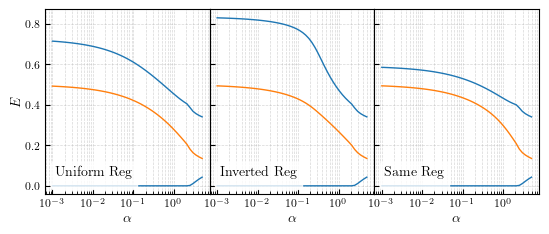

In [237]:

IMG_DIRECTORY = "./Assets/defence_sweep"
if not os.path.exists(IMG_DIRECTORY):
    os.makedirs(IMG_DIRECTORY)


def save_plot(fig, name, formats=["pdf","jpg"], date=False):
    current_date = datetime.datetime.now().strftime("%Y-%m-%d")
    for f in formats:        
        path = "{}".format(name) + "_{}".format(current_date) + "." + f
        if not date:
            path = "{}".format(name) + "." + f
        fig.savefig(            
            os.path.join(IMG_DIRECTORY, path),
            format=f,
        )


def set_size(width, fraction=1, subplots=(1, 1)):
    if width == "thesis":
        width_pt = 426.79135
    elif width == "beamer":
        width_pt = 307.28987
    else:
        width_pt = width

    fig_width_pt = width_pt * fraction
    inches_per_pt = 1 / 72.27

    golden_ratio = (5**0.5 - 1) / 2

    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * (golden_ratio) * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


# width = 2.5 * 458.63788
multiplier = 1.25
width = multiplier * 1.5 * 234.8775

# plt.style.use("../latex_ready.mplstyle")

tuple_size = set_size(width, fraction=1.0, subplots=(1, 2))
tuple_size = (3*8.5/4,2.4)

multiplier = 1.25
second_multiplier = 0.6

data_to_save = {}

# import Line2D for custom legend
from matplotlib.lines import Line2D

fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    sharex=True,
    sharey=True,
    figsize=( tuple_size[0], tuple_size[1]),
    gridspec_kw={"hspace": 0,"wspace": 0},
)


# ICML adjustments
# fig.subplots_adjust(left=0.08)
# fig.subplots_adjust(bottom=0.12)
# fig.subplots_adjust(top=0.99)
# fig.subplots_adjust(right=0.97)

print("Figure size in inches: ", fig.get_size_inches())

axes = axes.flatten()

# Create a custom legend
custom_legend = []


for df_idx, (key, value) in enumerate(df_dict.items()):

    data_model_name = key

    axs = axes[df_idx]
    

    linestyles = ["solid", "dashed", "dashdot", "dotted"]

    for idx, (epsilon, eps_dict) in enumerate(value.items()):

        ax = axes[idx]

        alphas = eps_dict["alphas"]
        adversarial_error = eps_dict["adversarial_error"]
        generalization_error = eps_dict["generalization_error"]
        boundary_error = eps_dict["boundary_error"]
        class_preserving = eps_dict["class_preserving"]
        tra = eps_dict["training_error"]

        adversarial_error_erm = eps_dict["adversarial_error_erm"]
        generalization_error_erm = eps_dict["generalization_error_erm"]
        boundary_error_erm = eps_dict["boundary_error_erm"]
        class_preserving_erm = eps_dict["class_preserving_erm"]

        adversarial_error_erm_std = eps_dict["adversarial_error_erm_std"]
        generalization_error_erm_std = eps_dict["generalization_error_erm_std"]
        boundary_error_erm_std = eps_dict["boundary_error_erm_std"]
        class_preserving_erm_std = eps_dict["class_preserving_erm_std"]

        if df_idx == 0:

            custom_legend.append(Line2D([0],[0],color="C0", linestyle=linestyles[idx], label=r"$E_{{\mathrm{{adv}}}}, \varepsilon_t={}$".format(epsilon)))
            custom_legend.append(Line2D([0],[0],color="C1", linestyle=linestyles[idx], label=r"$E_{{\mathrm{{gen}}}}, \varepsilon_t={}$".format(epsilon)))
            custom_legend.append(Line2D([0],[0],color="C2", linestyle=linestyles[idx], label=r"$E_{{\mathrm{{bound}}}}, \varepsilon_t={}$".format(epsilon)))
            custom_legend.append(Line2D([0],[0],color="C3", linestyle=linestyles[idx], label=r"$E_{{\mathrm{{CP}}}}, \varepsilon_t={}$".format(epsilon)))
        

        adversarial_lines = axs.plot(alphas, adversarial_error, linestyle=linestyles[idx],color="C0")
        axs.plot(alphas, generalization_error, linestyle=linestyles[idx],color="C1")
        axs.plot(alphas, tra)

        dd = {"alphas" : alphas, "adversarial_error" : adversarial_error, "generalization_error" : generalization_error, "training_error" : tra}

        data_to_save.update({data_model_name[-5:] : dd})

        print(eps_dict)
        # axs.plot(alphas, boundary_error,linestyle=linestyles[idx], color="C2")
        # axs.plot(alphas, class_preserving,linestyle=linestyles[idx], color="C3")

        axs.errorbar(
            alphas,
            adversarial_error_erm,
            yerr=adversarial_error_erm_std,
            fmt=".",
            markersize=1,
            color="C0"
        )
        axs.errorbar(
            alphas,
            generalization_error_erm,
            yerr=generalization_error_erm_std,
            fmt=".",
            markersize=1,
            color="C1"
        )
        axs.errorbar(
            alphas,
            boundary_error_erm,
            yerr=boundary_error_erm_std,
            fmt=".",
            markersize=1,
            color="C2"
        )
        axs.errorbar(
            alphas,
            class_preserving_erm,
            yerr=class_preserving_erm_std,
            fmt=".",
            markersize=1,
            color="C3"
        )


    axs.set_xscale("log")
    # axs.set_yscale("log")


    if df_idx == 0:
        axs.set_ylabel(r"$E$", labelpad=2.0)
    # axs.set_ylabel(r"$E$", labelpad=2.0)


    axs.set_xlabel(r"$\alpha$", labelpad=2.0)
    axs.grid(which="both", axis="both", alpha=0.5)
    print(data_model_name[-5:])
    print(data_model_name[-8:])
    if data_model_name[-5:] == "[1 1]":
        m = "Uniform Reg"
    elif data_model_name[-5:] == "[1 5]":
        m = "Same Reg"
    elif data_model_name[-5:] == "[5 1]":
        m = "Inverted Reg"
    # axs.legend(title=data_model_name, loc="lower left")
    axs.legend(title=m, loc="lower left")
    # Set the major ticks to face inwards
    axs.tick_params(axis='both', which='major', direction='in')

    # Set the minor ticks to face inwards
    axs.tick_params(axis='both', which='minor', direction='in')


error_legend = []

error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{adv}}$",color="C0"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{gen}}$",color="C1"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{bound}}$",color="C2"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{CP}}$",color="C3"))

epsilon_legend = []

for idx, epsilon in enumerate(epsilons):
    epsilon_legend.append(Line2D([0],[0],color="black", linestyle=linestyles[idx], label=r"$\varepsilon_t={}$".format(epsilons[idx]))) 

custom_legend = []

# for idx in range(3):
    # custom_legend.append(error_legend[idx])
    # custom_legend.append(epsilon_legend[idx])

custom_legend.append(error_legend[-1])

# Place the legend at the bottom of the figure
# fig.legend(handles=custom_legend, loc='upper center', ncol=4)

save = True
if save:
    save_plot(
        fig,
        f"defence_sweep",
    )

plt.show()





In [238]:
import pickle

# Save data_to_save using pickle
with open('data_eps_0.15.pickle', 'wb') as f:
    pickle.dump(data_to_save, f)


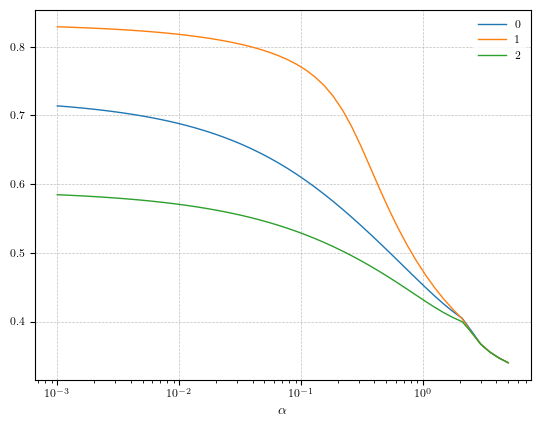

In [239]:
for df_idx, (key, value) in enumerate(df_dict.items()):

    data_model_name = key

    for idx, (epsilon, eps_dict) in enumerate(value.items()):


        alphas = eps_dict["alphas"]
        adversarial_error = eps_dict["adversarial_error"]
        generalization_error = eps_dict["generalization_error"]
        boundary_error = eps_dict["boundary_error"]
        class_preserving = eps_dict["class_preserving"]
        tra = eps_dict["training_error"]

        adversarial_error_erm = eps_dict["adversarial_error_erm"]
        generalization_error_erm = eps_dict["generalization_error_erm"]
        boundary_error_erm = eps_dict["boundary_error_erm"]
        class_preserving_erm = eps_dict["class_preserving_erm"]

        adversarial_error_erm_std = eps_dict["adversarial_error_erm_std"]
        generalization_error_erm_std = eps_dict["generalization_error_erm_std"]
        boundary_error_erm_std = eps_dict["boundary_error_erm_std"]
        class_preserving_erm_std = eps_dict["class_preserving_erm_std"]

        plt.plot(
            alphas, adversarial_error, label=df_idx, linestyle=linestyles[idx]
        )

plt.xlabel(r"$\alpha$")
plt.xscale("log")
plt.legend()
plt.grid(True)

plt.show()

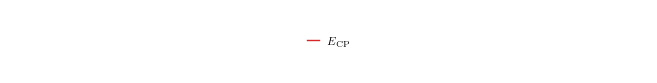

In [240]:
# save the legend separately, put the custom legend into a figure
figlegend = plt.figure(figsize=( tuple_size[0], 0.1 * tuple_size[0]))
plt.style.use("../latex_ready.mplstyle")
legend_ax = figlegend.add_axes([0, 0, 1, 1])
legend_ax.axis('off')  # Turn off the axes for the legend figure

figlegend.legend(
    handles=custom_legend,
    handlelength=1,
    loc="center",
    ncol=4,
)

figlegend.savefig(
    os.path.join(IMG_DIRECTORY, "legend.pdf"),
    format="pdf",
    # bbox_inches="tight",
)


plt.show()



Figure size in inches:  [0.6375 1.2   ]


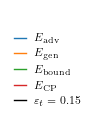

In [241]:
# save the legend separately, put the custom legend into a figure
figlegend = plt.figure(figsize=( 0.1*tuple_size[0], 0.5*tuple_size[1]))
plt.style.use("../latex_ready.mplstyle")
legend_ax = figlegend.add_axes([0, 0, 1, 1])
legend_ax.axis('off')  # Turn off the axes for the legend figure

# display figure size
print("Figure size in inches: ", figlegend.get_size_inches())

error_legend = []

error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{adv}}$",color="C0"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{gen}}$",color="C1"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{bound}}$",color="C2"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{CP}}$",color="C3"))

epsilon_legend = []

for idx, epsilon in enumerate(epsilons):
    epsilon_legend.append(Line2D([0],[0],color="black", linestyle=linestyles[idx], label=r"$\varepsilon_t={}$".format(epsilons[idx]))) 


# merge the two legends by concatenating the lists
custom_legend = error_legend + epsilon_legend


figlegend.legend(
    handles=custom_legend,
    handlelength=1,
    loc="center",
    ncol=1,
)

figlegend.savefig(
    os.path.join(IMG_DIRECTORY, "vertical_legend.pdf"),
    format="pdf",
    # bbox_inches="tight",
)


plt.show()

